In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 
from numpy.fft import fftshift
from tqdm import tqdm

import lensit as li
from lensit.clusterlens import lensingmap, profile 
from lensit.misc.misc_utils import gauss_beam
from lensit.ffs_covs import ffs_cov, ell_mat
from plancklens.wigners import wigners
from plancklens import n0s, nhl
from plancklens.n1 import n1

import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline

In [2]:
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname('/Users/sayan/CMB_WORK/CAMB-1.1.3/inifiles'),  'inifiles', cambinifile + '.ini'))
results = camb.get_results(pars)

In [8]:
# We define here the parameters for the profile of the cluster
M200, z = 2 * 1e14, 0.7
profname = 'nfw'
key = "lss" # "lss"/"cluster"/"lss_plus_cluster"
profparams={'M200c':M200, 'z':z}
hprofile = profile.profile(results, profname)
xmax = 3*hprofile.get_concentration(M200, z)
# Define here the map square patches
npix = 1024  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

print("The size of the data patch is %0.1f X %0.1f arcmin central box"%(npix*lpix_amin, npix*lpix_amin))

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 6002 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 4000
ellmindat = 100

# Number of simulated maps 
nsims = 1000

# Set CMB experiment for noise level and beam
cmb_exp='S4_sayan'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile,  profname, key, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
#libdir = op.join(libdir,"trunc")
print(libdir)

The size of the data patch is 307.2 X 307.2 arcmin central box
/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_sayan/nfw_profile/lensed_by_lss/npix1024_lpix_0.3amin_lmaxsky6002/M200_2.000000E+14_z0.7/1000_sims


In [5]:
lmax = ellmaxsky
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]

camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_len_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_gradient_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_gradlen_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[4], 'pp':cpp_fid}


In [9]:
np.random.seed(seed=20)
clustermaps = lensingmap.cluster_maps(libdir, key, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, ellmin_data=ellmindat, cmb_exp=cmb_exp)

In [10]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 4 * 0.25 

def p_to_k(ls):
    return ls * (ls+1.) * 0.5

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

def k_to_p(ls):
    return cli(p_to_k(ls))

def th_amin_to_el(th_amin):
    th_rd = (th_amin/60)*(np.pi/180)
    return np.pi/th_rd

In [11]:
ellmax_sky = clustermaps.ellmax_sky
sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(clustermaps.cmb_exp)

cls_noise = {'t': (sN_uKamin * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'q':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'u':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1)}  # simple flat noise Cls
# cl_transf = gauss_beam(Beam_FWHM_amin / 60. * np.pi / 180., lmax=ellmax_sky)
# lib_alm = ell_mat.ffs_alm_pyFFTW(get_ellmat(LD_res, HD_res=HD_res),
                    # filt_func=lambda ell: (ell >= ellmin) & (ell <= ellmax), num_threads=pyFFTWthreads)
# lib_skyalm = ell_mat.ffs_alm_pyFFTW(clustermaps.ellmat,
                    # filt_func=lambda ell: (ell <= ellmax_sky), num_threads=clustermaps.num_threads)

cl_transf = clustermaps.cl_transf
lib_skyalm = clustermaps.lib_skyalm

typ = 'T'

lib_dir = op.join(clustermaps.dat_libdir, typ)
# isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, cls_len, cl_transf, cls_noise, lib_skyalm=lib_skyalm)
isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, cls_unl_fid, cls_unl_fid, cl_transf, cls_noise, lib_skyalm=lib_skyalm)

In [32]:
H0unl =  isocov.get_response(typ, lib_skyalm, use_cls_len=False)[0]
H0len =  isocov.get_response(typ, lib_skyalm, use_cls_len=True)[0]
#H0len1 =  isocov.get_response(typ, lib_skyalm, cls_cmb=cls_gradlen_fid, use_cls_len=True)[0]
#H0len = phi_var_3
def get_starting_point(idx, typ, clustermaps, keyword=None): 
    """
    This returns initial data for simulation index 'idx' from a CMB-S4 simulation library.
    On first call the simulation library will generate all simulations phases, hence might take a little while.
    """ 

    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
 
    lib_qlm = lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.
    ellmax_sky = lib_skyalm.ellmax
    ell = np.arange(ellmax_sky+1)

    if typ=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in clustermaps.maps_lib.get_sim_qumap(idx)]) 
    elif typ =='T':
        datalms = np.array([isocov.lib_datalm.map2alm(clustermaps.maps_lib.get_sim_tmap(idx))]) 
    elif typ =='TQU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in np.array([clustermaps.maps_lib.get_sim_tmap(idx), clustermaps.maps_lib.get_sim_qumap(idx)[0], clustermaps.maps_lib.get_sim_qumap(idx)[1]])]) 
   
    use_cls_len = True
 
    plm1 = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len)[0]

    
    plm2 = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len, ellmax_gradleg=2000)[0]

    return  plm1, plm2


idx = 0
plm1, plm2 = get_starting_point(idx, typ, clustermaps)

  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   inverse unl Pmats  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxx , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fyy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxx , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fyy , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxy , part 2  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   inverse len Pmats  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxx , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fyy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:00])   Fxy , part 1  curvpOlm 
  lensit.ffs_covs.ffs_cov   [00:00:00]  (total [00:00:0

In [33]:
nmaps = 1000
plms1 = [None]*nmaps
plms2 = [None]*nmaps


if nsims >1:
    for idx in range(nmaps):
        print(idx)
        plms1[idx], plms2[idx] = get_starting_point(idx, typ, clustermaps)

0
 I will be using data from ell=140 to ell=5000 only
 The sky band-limit is ell=6002
Building nufft fwd plan
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
1
 I will be using data from ell=140 to ell=5000 only
 The sky band-limit is ell=6002
Building nufft fwd plan
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00

In [11]:
H0_len_old = np.loadtxt("/Users/sayan/Project_Geneva/cluster_lensing_files-main/Final_notebooks/CSTMF/June23/bias_sup/H0len_2.txt")[:ellmax_sky+1]

In [21]:
ell, = np.where(isocov.lib_skyalm.get_Nell()[:6000+1])
el = ell[1:]

In [34]:
phi_lm_input = nmaps*[None]
for idx in tqdm(range(nmaps)):
    phi_lm_input[idx] = lib_skyalm.map2alm(clustermaps.len_cmbs._get_f(idx).get_phi())

100%|██████████| 1000/1000 [02:53<00:00,  5.78it/s]


In [35]:
cross_corr1 = nmaps*[None]
cross_corr2 = nmaps*[None]
for idx in tqdm(range(nmaps)):
    cross_corr1[idx] = lib_skyalm.alm2cl(plms1[idx], phi_lm_input[idx])
    cross_corr2[idx] = lib_skyalm.alm2cl(plms2[idx], phi_lm_input[idx])

H0_len1_emp = np.mean(cross_corr1, axis=0)/cpp_fid[:ellmax_sky+1]
H0_len2_emp = np.mean(cross_corr2, axis=0)/cpp_fid[:ellmax_sky+1]

100%|██████████| 1000/1000 [00:16<00:00, 58.88it/s]
/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_73139/1872370865.py:7: RuntimeWarning: invalid value encountered in true_divide
  H0_len1_emp = np.mean(cross_corr1, axis=0)/cpp_fid[:ellmax_sky+1]
/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_73139/1872370865.py:8: RuntimeWarning: invalid value encountered in true_divide
  H0_len2_emp = np.mean(cross_corr2, axis=0)/cpp_fid[:ellmax_sky+1]


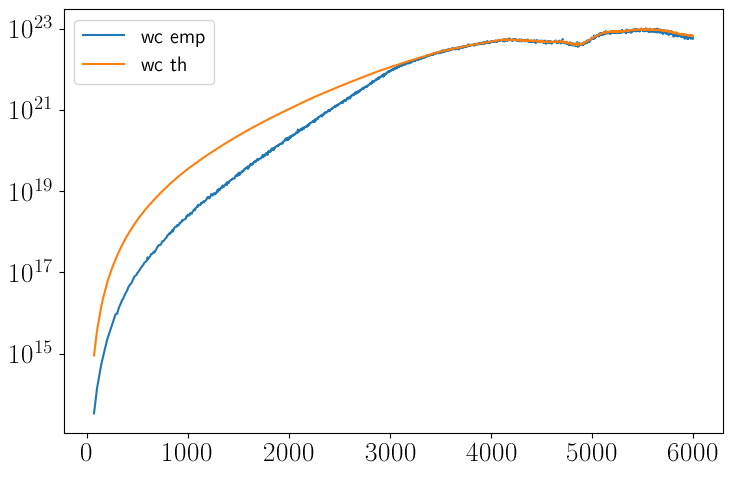

In [38]:
plt.plot(el, H0_len2_emp[el], label="wc emp")
plt.plot(el, H0len[el], label="wc th")
plt.semilogy()
plt.legend()

In [25]:
H0_len_old.shape
print(np.mean(H0_len2_emp[el]/H0_len_old[el]))

0.9861779813544846


In [39]:
np.savetxt("./emp_response/H0len_gad_cut_lmax5k_out6k_wo_noise.txt", H0_len2_emp)

In [24]:
np.savetxt("./emp_response/H0len_wc_lmax4k_out6k.txt", H0_len1_emp)

In [79]:
np.savetxt("../cluster_runs/ratio_old_v_new.txt", (H0_len_old/H0_len2_emp))

/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_23207/3182285709.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.savetxt("../cluster_runs/ratio_old_v_new.txt", (H0_len_old/H0_len2_emp))


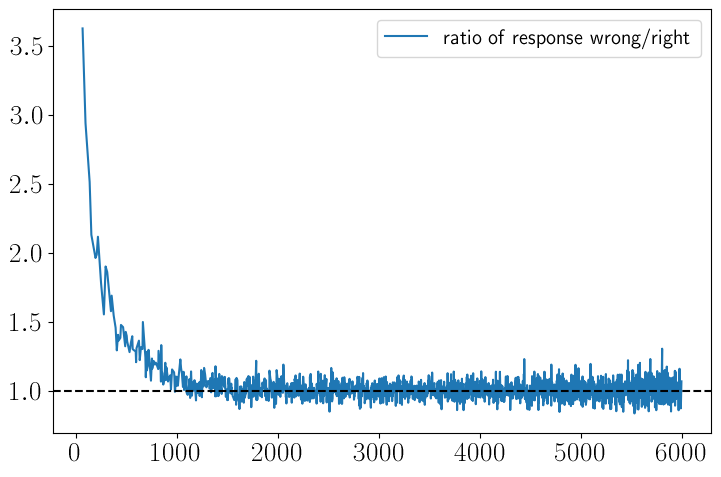

In [24]:
#plt.plot(el, H0_len_old[el], label="old and wrong")
#plt.plot(el, H0_len2_emp[el], label="new and right")
#ratio
plt.plot(el, (H0_len_old[el]/H0_len2_emp[el]), label="ratio of response wrong/right")
plt.axhline(1, color="k", ls="--")
#plt.plot(el, H0_len1_emp[el], label="without the cut new and right")
#plt.semilogy()
plt.legend()

In [14]:
H0len_J = np.loadtxt('Sans titre')

In [15]:

ell, = np.where(isocov.lib_skyalm.get_Nell()[:ellmax_sky+1])
el = ell[1:]

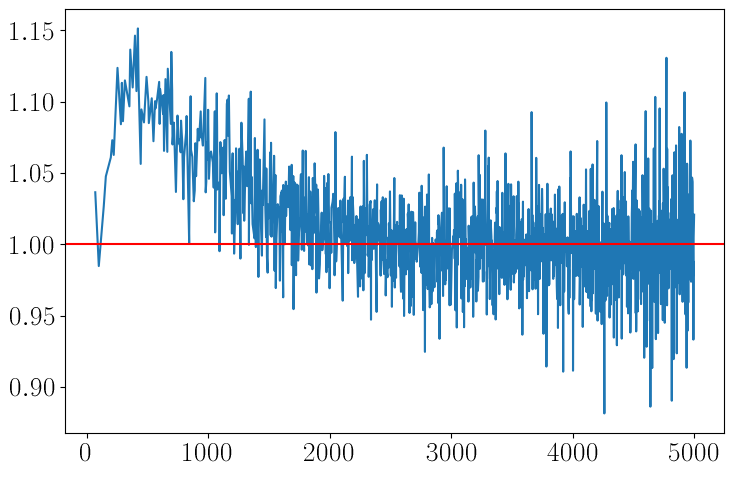

In [18]:
plt.plot(el, H0_len1_emp[el]/H0len[el])
plt.axhline(y=1, color='r')

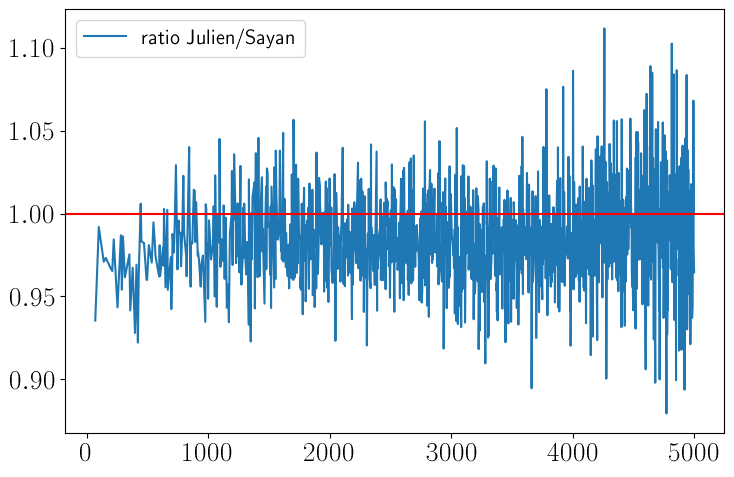

In [60]:
#plt.plot(el, H0_len22_emp[el]/H0_len11_emp[el] , label="response ratio Sayan")
#plt.plot(el, H0len[el], label="response WO cut Sayan using len Cls")
#plt.plot(el, H0len1[el], label="response WO cut Sayan using Gradlen Cls")
#plt.plot(el, H0unl[el], label="response WO cut Sayan using unl Cls")
#plt.plot(el, H0_len11_emp[el], label="response Sayan WO Cut")
#plt.plot(el, H0_len1_emp[el], label="response Sayan W Cut")
#plt.plot(el, H0len_J[el,2]/H0len_J[el,1], label="response ratio Julien")
#plt.plot(el, H0len_J[el,1]*pp_to_kk(el), label="response Julien WO cut")
plt.plot(el, H0len_J[el,1]*pp_to_kk(el)/H0_len11_emp[el], label="ratio Julien/Sayan")
plt.axhline(y=1, color='r')
#plt.semilogy()
plt.legend()

In [23]:
def get_starting_point(idx, typ, clustermaps, keyword=None): 
    """
    This returns initial data for simulation index 'idx' from a CMB-S4 simulation library.
    On first call the simulation library will generate all simulations phases, hence might take a little while.
    """ 

    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
 
    lib_qlm = lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.
    ellmax_sky = lib_skyalm.ellmax
    ell = np.arange(ellmax_sky+1)

    if typ=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in clustermaps.maps_lib.get_sim_qumap(idx)]) 
    elif typ =='T':
        datalms = np.array([isocov.lib_datalm.map2alm(clustermaps.maps_lib.get_sim_tmap(idx))]) 
    elif typ =='TQU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in np.array([clustermaps.maps_lib.get_sim_tmap(idx), clustermaps.maps_lib.get_sim_qumap(idx)[0], clustermaps.maps_lib.get_sim_qumap(idx)[1]])]) 
   
    use_cls_len = True
 
    plm1 = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len, ellmax_gradleg=2000)[0]
    
    # Normalization and Wiener-filtering:
    plmqe1  = lib_qlm.almxfl(plm1, cli(H0len_1), inplace=False)

    # We now build the Wiener-filtered quadratic estimator. We use lensed CMB spectra in the weights.

    if typ=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in clustermaps.maps_lib.get_sim_qumap_unl(idx)]) 
    elif typ =='T':
        datalms = np.array([isocov.lib_datalm.map2alm(clustermaps.maps_lib.get_sim_tmap_unl(idx))]) 
    elif typ =='TQU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in np.array([clustermaps.maps_lib.get_sim_tmap_unl(idx), clustermaps.maps_lib.get_sim_qumap_unl(idx)[0], clustermaps.maps_lib.get_sim_qumap_unl(idx)[1]])]) 


    plm2 = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len, ellmax_gradleg=2000)[0]
    
    # Normalization and Wiener-filtering:
    plmqe2  = lib_qlm.almxfl(plm2, cli(H0len_1), inplace=False)

    return  plmqe1 , plmqe2


idx = 0
plmqe1, plmqe2= get_starting_point(idx, typ, clustermaps)

 I will be using data from ell=140 to ell=5000 only
 The sky band-limit is ell=5999
Building nufft fwd plan
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


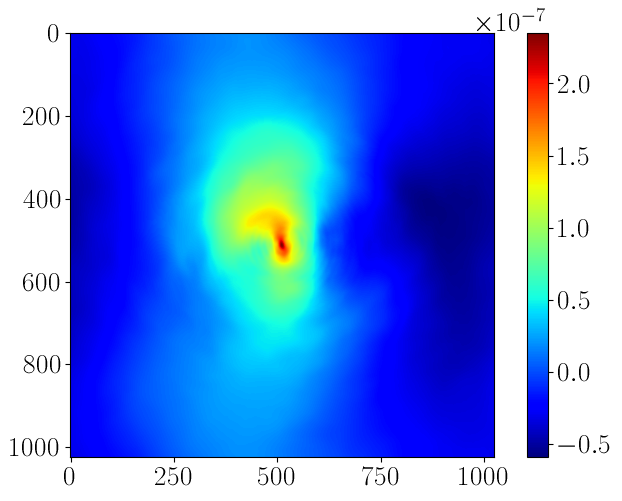

In [104]:
plt.imshow(fftshift(lib_skyalm.alm2map(plmqe1-plmqe2)), cmap=plt.cm.jet)
plt.colorbar()

In [24]:
nmaps = 1000
plmqes1 = [None]*nmaps
plmqes2 = [None]*nmaps
plmqes_1 = [None]*nmaps

if nsims >1:
    for idx in range(nmaps):
        print(idx)
        plmqes1[idx], plmqes2[idx]= get_starting_point(idx, typ, clustermaps)
        plmqes_1[idx] = plmqes1[idx] - plmqes2[idx]

0
 I will be using data from ell=140 to ell=5000 only
 The sky band-limit is ell=5999
Building nufft fwd plan
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
1
 I will be using data from ell=140 to ell=5000 only
 The sky band-limit is ell=5999
Building nufft fwd plan
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00

In [25]:
plmqe_mean_2 = np.mean(plmqes_1, axis=0)

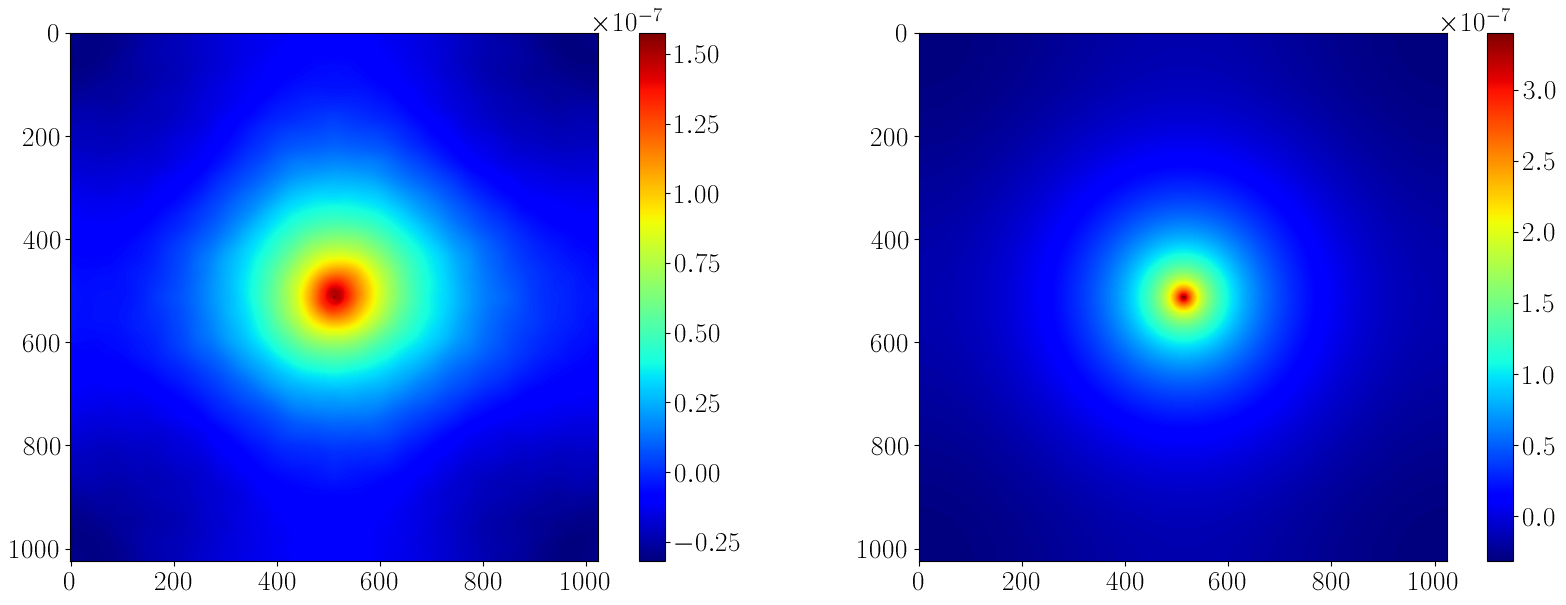

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)
phi_input = clustermaps.len_cmbs._get_f(0).get_phi()

fig.subplots_adjust(left=0.02, bottom=0.06, right=1.4, top=0.94, wspace=0.05)
# for ax, dat in zip(axs, [lib_qlm.alm2map(plm2klm(plm0)), clustermaps.len_cmbs.kappa_map]):
for ax, dat in zip(axs, [fftshift(phi_input - lib_skyalm.alm2map(plmqe_mean_1)), fftshift(phi_input)]):
    im = ax.imshow(dat, cmap=plt.cm.jet)
    fig.colorbar(im, ax=ax)

In [27]:
ell = np.arange(ellmax_sky)
kappa_l_mean_2 = lib_skyalm.bin_realpart_inell(plmqe_mean_2)*p_to_k(ell)
kappa_lm_mean_2 = lib_skyalm.almxfl(plmqe_mean_2, p_to_k(ell), inplace=False)
#phi_l_mean = lib_skyalm.bin_realpart_inell(plmqe_mean)
phi_l_mean_2 = lib_skyalm.bin_realpart_inell(plmqe_mean_2)
phi_l = kappa_l*k_to_p(ell)


In [28]:
ell = np.arange(ellmax_sky)

lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
lbox_rad = (lbox_amin/60)*(np.pi/180)
kappa_map = clustermaps.len_cmbs.kappa_map
from scipy.interpolate import UnivariateSpline
kappa_ell_bin = lib_skyalm.bin_realpart_inell(lib_skyalm.map2alm(kappa_map))[ell]
kappa_ell_lensit = UnivariateSpline(ell, kappa_ell_bin, s=0)
kappa_l = kappa_ell_lensit(ell)

In [29]:
ft_anal = hprofile.analitic_kappa_ft(M200, z, xmax, ell)

/Users/sayan/Project_Geneva/modules/LensIt/lensit/clusterlens/profile.py:191: RuntimeWarning: invalid value encountered in subtract
  Cidiff = Cixpc - Cix
/Users/sayan/Project_Geneva/modules/LensIt/lensit/clusterlens/profile.py:192: RuntimeWarning: invalid value encountered in true_divide
  u0 = np.sin(x) * Sidiff + np.cos(x) * Cidiff - np.sin(x * xmax) / (x * (1. + xmax))


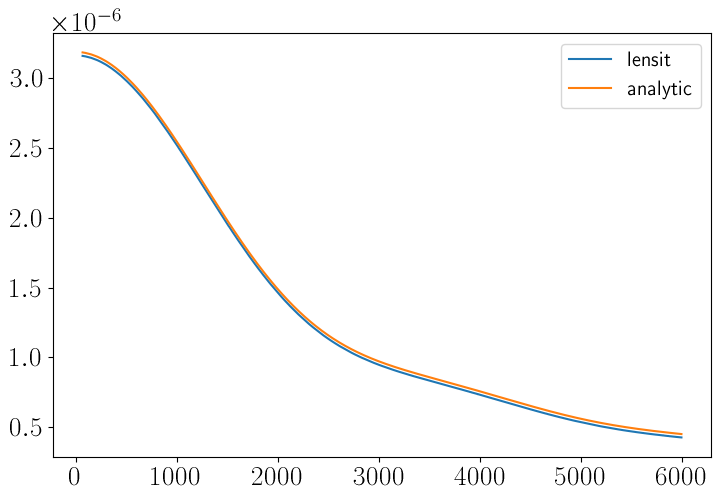

In [31]:
plt.plot(el, kappa_l[el], label='lensit')
plt.plot(el, ft_anal[el]/lbox_rad, label='analytic')
plt.legend()


<>:6: DeprecationWarning: invalid escape sequence \e
<>:7: DeprecationWarning: invalid escape sequence \p
<>:6: DeprecationWarning: invalid escape sequence \e
<>:7: DeprecationWarning: invalid escape sequence \p
/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_2638/3251252984.py:6: DeprecationWarning: invalid escape sequence \e
  plt.xlabel("$\ell$")
/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_2638/3251252984.py:7: DeprecationWarning: invalid escape sequence \p
  plt.ylabel("$\phi_\ell$")


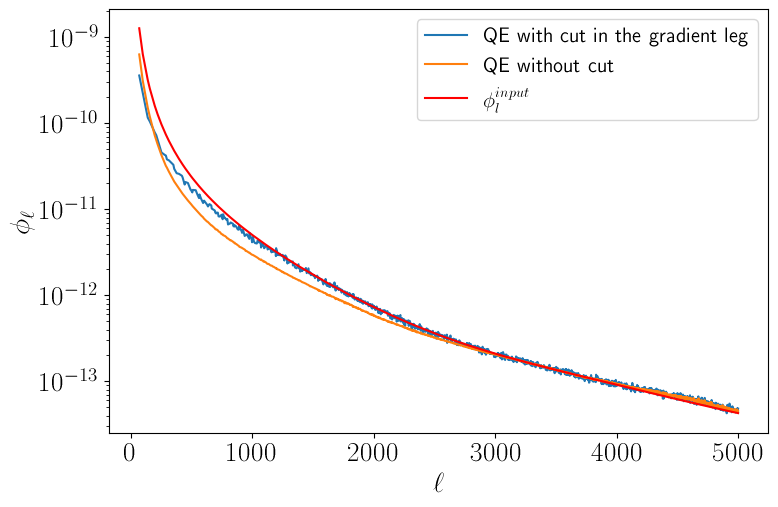

In [109]:
plt.plot(el, phi_l_mean_1[el], label="QE with cut in the gradient leg")
plt.plot(el, phi_l_mean[el], label="QE without cut")
plt.plot(el, phi_l[el], c="r", label=r'$\phi_l^{input}$')

plt.semilogy()
plt.xlabel("$\ell$")
plt.ylabel("$\phi_\ell$")
plt.legend()

In [65]:
kappa_l_mean = np.loadtxt("./files/kappa_l_MAP_QEwc_QEc_lmaxsky5k.dat")[0]
kappa_l_mean_1 = np.loadtxt("./files/kappa_l_MAP_QEwc_QEc_lmaxsky5k.dat")[1]


<>:11: DeprecationWarning: invalid escape sequence \e
<>:12: DeprecationWarning: invalid escape sequence \k
<>:11: DeprecationWarning: invalid escape sequence \e
<>:12: DeprecationWarning: invalid escape sequence \k
/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_2802/1179336524.py:11: DeprecationWarning: invalid escape sequence \e
  plt.xlabel("$\ell$")
/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_2802/1179336524.py:12: DeprecationWarning: invalid escape sequence \k
  plt.ylabel("$\kappa_\ell$")


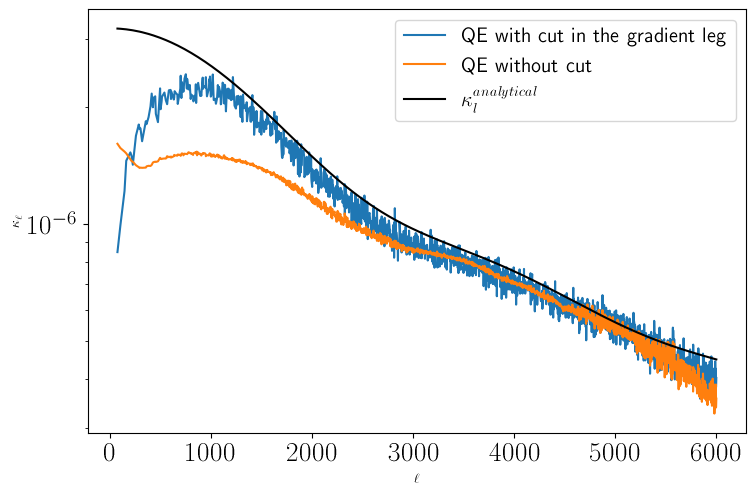

In [33]:
ell, = np.where(isocov.lib_skyalm.get_Nell()[:ellmax_sky+1])
el = ell[1:]

#plt.plot(el, kappa_l_mean[el], label="MAP")
plt.plot(el, kappa_l_mean_2[el], label="QE with cut in the gradient leg")
plt.plot(el, kappa_l_mean[el], label="QE without cut")
#plt.plot(el, kappa_l[el], c="r", label=r'$\kappa_l$ from capped profile')
plt.plot(el, ft_anal[el]/(lbox_rad), c="k", label=r'$\kappa_l^{analytical}$')

plt.semilogy()
plt.xlabel("$\ell$")
plt.ylabel("$\kappa_\ell$")
plt.legend()
#plt.savefig("../plots/kappa_l.pdf")

In [12]:
el_r, = np.where(isocov.lib_skyalm.get_Nell()[:ellmax_sky])

In [13]:
el_r.shape

(1883,)

In [18]:
from scipy.special import jv
def kappa_th_bessel(theta_amin, kappa_l, elmax):
    el_r, = np.where(isocov.lib_skyalm.get_Nell()[:elmax+1])
    el_range = el_r[1:]
    theta_rad = theta_amin * np.pi / 60 / 180
    kappa_el = kappa_l[el_range]
    bessel = jv(0, el_range*theta_rad)
    integrand = el_range*kappa_el*bessel
    kappa_el1 = np.trapz(integrand, el_range)/ 2 / np.pi 
    return kappa_el1

In [16]:
theta = np.linspace(0, 10, num=100)

In [17]:
kappa_thet_bessel = np.zeros((len(theta)))
kappa_thet_bessel_uc = np.zeros((len(theta)))
#kappa_thet_bessel_c = np.zeros((len(theta)))
#kappa_thet_bessel_wc = np.zeros((len(theta)))
for th in tqdm(range(len(theta))):
    kappa_thet_bessel[th] = kappa_th_bessel(theta[th], kappa_l, elmax=ellmaxsky)
    kappa_thet_bessel_uc[th] = kappa_th_bessel(theta[th], ft_anal, elmax=ellmaxsky)
#    kappa_thet_bessel_c[th] = kappa_th_bessel(theta[th], kappa_l_mean_1, elmax=ellmaxsky)
#    kappa_thet_bessel_wc[th] = kappa_th_bessel(theta[th], kappa_l_mean, elmax=ellmaxsky)

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'kappa_th_bessel' is not defined

In [19]:
plt.plot(theta, kappa_thet_bessel*lbox_rad, label=r" capped $\kappa(\theta)$")
plt.plot(theta, kappa_thet_bessel_uc, label=r" uncapped $\kappa(\theta)$")
plt.legend()

NameError: name 'lbox_rad' is not defined

In [35]:
data_1 = lib_skyalm.alm2map(kappa_lm_mean)
data_2 = lib_skyalm.alm2map(kappa_lm_mean_1)
data_3 = clustermaps.len_cmbs._get_f(0).get_kappa()

#data_1 = lib_skyalm.alm2map(plmqe_mean)
#data_2 = lib_skyalm.alm2map(plmqe_mean_1)
#data_3 = clustermaps.len_cmbs._get_f(0).get_phi()


In [114]:
shape = np.array([npix,npix])
X, Y =  np.meshgrid(np.concatenate((np.arange(0,shape[0]//2), np.arange(-shape[0]//2,0))), np.concatenate((np.arange(0,shape[1]//2), np.arange(-shape[1]//2,0))))
data = kappa_map
radius = 10

In [115]:
# Calculate the distance from the center
center = (0, 0)  # Center coordinates of the dataset
distances = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

# Compute the average value for each distance
unique_distances = np.unique(distances)  # Unique distance values
unique_distances_1 = []
for distance in unique_distances:
    if distance*0.3 < radius:
        #print(distance)
        unique_distances_1 = np.append(unique_distances_1, distance)

In [116]:
mean_values_1 = []
for distance in tqdm(unique_distances_1):
    values = data_1[distances == distance]  # Values at the given distance
    mean_value = np.mean(values)  # Compute the mean value
    mean_values_1.append(mean_value)

100%|██████████| 365/365 [00:00<00:00, 946.40it/s]


In [117]:
mean_values_2 = []
for distance in tqdm(unique_distances_1):
    values = data_2[distances == distance]  # Values at the given distance
    mean_value = np.mean(values)  # Compute the mean value
    mean_values_2.append(mean_value)

100%|██████████| 365/365 [00:00<00:00, 1028.08it/s]


In [118]:
mean_values_3 = []
for distance in tqdm(unique_distances_1):
    values = data_3[distances == distance]  # Values at the given distance
    mean_value = np.mean(values)  # Compute the mean value
    mean_values_3.append(mean_value)

100%|██████████| 365/365 [00:00<00:00, 847.12it/s]


In [41]:
theta = np.linspace(0, 10, num=100)

In [39]:
ell = np.arange(ellmax_sky)

nmaps = 1000
kappa_l_1 = nmaps*[None]
kappa_l_ = nmaps*[None]
kappa_prof_th_1 = nmaps*[None]
kappa_prof_th_ = nmaps*[None]
for idx in tqdm(range(nmaps)):
    kappa_l_[idx] = lib_skyalm.bin_realpart_inell(plmqes[idx])*p_to_k(ell)
    kappa_l_1[idx] = lib_skyalm.bin_realpart_inell(plmqes_1[idx])*p_to_k(ell)
    kappa_th_ = np.zeros((len(theta)))
    kappa_th_1 = np.zeros((len(theta)))
    for th in range(len(theta)):
        kappa_th_[th] = kappa_th_bessel(theta[th], kappa_l_[idx], elmax=ellmaxsky)
        kappa_th_1[th] = kappa_th_bessel(theta[th], kappa_l_1[idx], elmax=ellmaxsky)
        
    kappa_prof_th_[idx] = kappa_th_
    kappa_prof_th_1[idx] = kappa_th_1

100%|██████████| 1000/1000 [08:05<00:00,  2.06it/s]


In [78]:
lib_skyalm.bin_realpart_inell(plmqes[10])[el]

array([ 1.03831975e-09,  5.48141516e-10,  1.98083049e-10, ...,
       -2.08209455e-14, -3.34950481e-15, -4.81658020e-15])

In [90]:
kappa_prof_th_error_n = np.std(kappa_prof_th_, axis=0)*lbox_rad

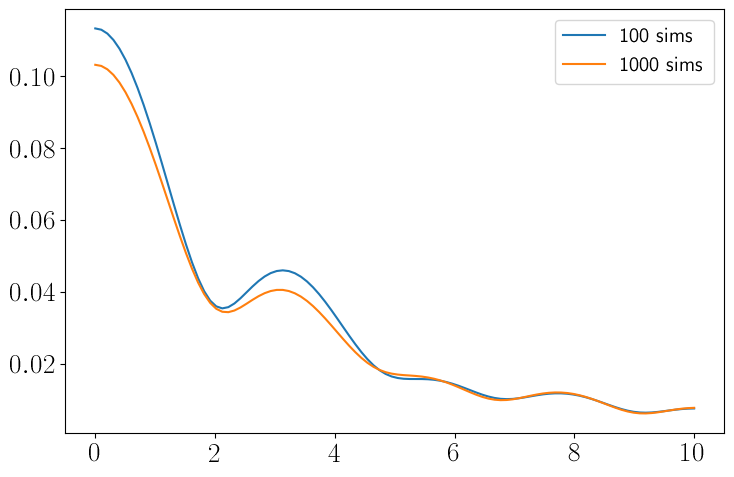

In [93]:
plt.plot(theta, kappa_prof_th_error, label="100 sims")
plt.plot(theta, kappa_prof_th_error_n, label="1000 sims")
plt.legend()


In [40]:
kappa_prof_th_mean_1 = np.mean(kappa_prof_th_, axis=0)*lbox_rad
kappa_prof_th_error_1 = np.std(kappa_prof_th_, axis=0)*lbox_rad/np.sqrt(1000)
kappa_prof_th_mean_2 = np.mean(kappa_prof_th_1, axis=0)*lbox_rad
kappa_prof_th_error_2 = np.std(kappa_prof_th_1, axis=0)*lbox_rad/np.sqrt(1000)


In [42]:
#theta = np.loadtxt("./files/kappa_th_map.dat")[0]
kappa_prof_th_mean = np.loadtxt("../cluster_runs/files_max5k_out6k/kappa_th_map_sm.dat")[1]
kappa_prof_th_error = np.loadtxt("../cluster_runs/files_max5k_out6k/kappa_th_map.dat")[2]
#kappa_prof_th_mean_1 = np.loadtxt("./files/kappa_th_qe_wc.dat")[1]
#kappa_prof_th_error_1 = np.loadtxt("./files/kappa_th_qe_wc.dat")[2]
#kappa_prof_th_mean_2 = np.loadtxt("./files/kappa_th_qe_c.dat")[1]
#kappa_prof_th_error_2 = np.loadtxt("./files/kappa_th_qe_c.dat")[2]

In [44]:
import matplotlib.patches as mpatches


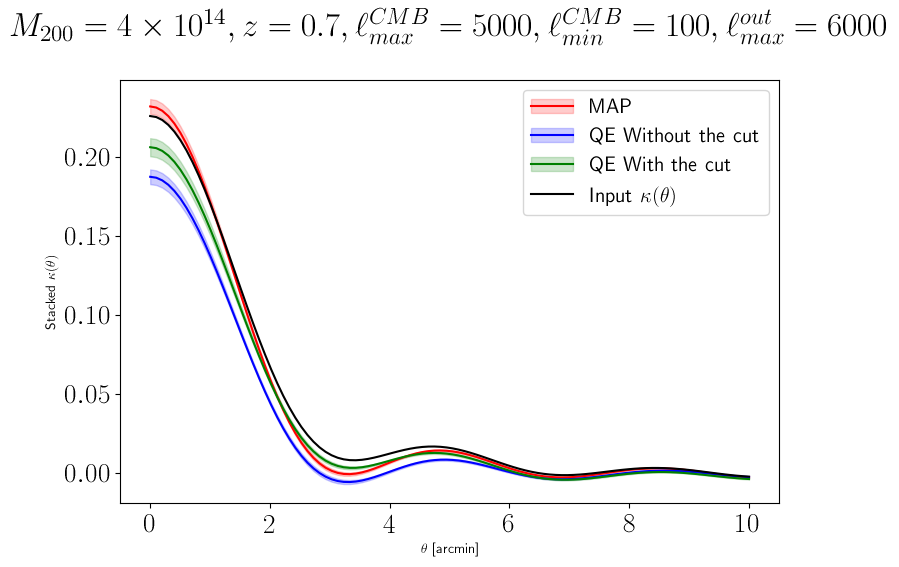

In [45]:
styles = {
    'MAP': {
        'color': 'red',
        'label': 'Without the cut',
        'fill_color': 'red'
    },
    'QE_without_cut': {
        'color': 'blue',
        'label': 'With the cut',
        'fill_color': 'blue'
    },
    'QE_with_cut': {
        'color': 'green',
        'label': 'With the cut',
        'fill_color': 'green'
    },    
    'input_kappa': {
        'color': 'black',
        'label': r'Input $\kappa (\theta)$'
    }
}

fig, ax = plt.subplots()

# Plot with MAP
line1, = ax.plot(theta, kappa_prof_th_mean, color=styles['MAP']['color'])
error1 = ax.fill_between(theta, kappa_prof_th_mean - kappa_prof_th_error, kappa_prof_th_mean + kappa_prof_th_error,
                         alpha=0.2, color=styles['MAP']['fill_color'])

 #Plot with QE with cut
line2, = ax.plot(theta, kappa_prof_th_mean_1, color=styles['QE_without_cut']['color'])
error2 = ax.fill_between(theta, kappa_prof_th_mean_1 - kappa_prof_th_error_1, kappa_prof_th_mean_1 + kappa_prof_th_error_1,
                         alpha=0.2, color=styles['QE_without_cut']['fill_color'])

# Plot with QE without cut
line3, = ax.plot(theta, kappa_prof_th_mean_2, color=styles['QE_with_cut']['color'])
error3 = ax.fill_between(theta, kappa_prof_th_mean_2 - kappa_prof_th_error_2, kappa_prof_th_mean_2 + kappa_prof_th_error_2,
                         alpha=0.2, color=styles['QE_with_cut']['fill_color'])

# Plot input kappa
line4, = ax.plot(theta, kappa_thet_bessel_uc, color=styles['input_kappa']['color'])

# Set labels and title
ax.set_xlabel(r'$\theta$ [arcmin]')
ax.set_ylabel(r'Stacked $\kappa(\theta)$')
ax.set_title(r'$M_{200} = 4 \times 10^{14}, z=0.7, \ell_{max}^{CMB}=5000, \ell_{min}^{CMB}=100, \ell_{max}^{out}=6000$',
             y=1.08)

# Create custom legend handles for shaded regions with lines
error_patch1 = mpatches.Patch(color=styles['MAP']['fill_color'], alpha=error1.get_alpha(), label='Error')
error_patch2 = mpatches.Patch(color=styles['QE_without_cut']['fill_color'], alpha=error2.get_alpha(), label='Error')
error_patch3 = mpatches.Patch(color=styles['QE_with_cut']['fill_color'], alpha=error3.get_alpha(), label='Error')

# Show the legend with custom handles
ax.legend([(line1, error_patch1), (line2, error_patch2), (line3, error_patch3), line4], ['MAP','QE Without the cut','QE With the cut', r'Input $\kappa (\theta)$'])

# Show the plot
#plt.show()

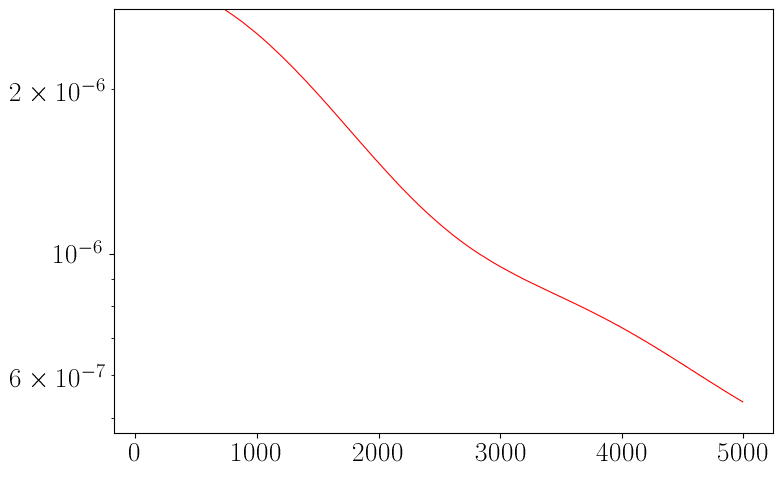

In [53]:
plt.plot(el, kappa_l[el], lw=0.8, c="r")
# Set limit on y axis 
plt.ylim(top=2.8e-6, bottom=4.7e-7)
#plt.xticks([])
#plt.yticks([])
plt.semilogy()
plt.savefig("plot.png", transparent=True)

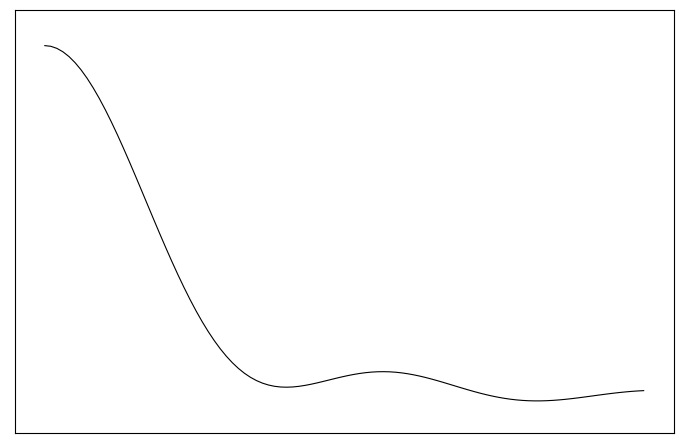

In [37]:
plt.plot(theta, kappa_thet_bessel * lbox_rad, lw=0.8, c="k")
# Set limit on y axis 
plt.ylim(top=0.2015, bottom=-0.02)
plt.xticks([])
plt.yticks([])
plt.savefig("plot.png", transparent=True)

In [76]:
theta_1 = np.linspace(0, 40, num=1000)
phi_thet_bessel = np.zeros((len(theta_1)))
phi_thet_bessel_c = np.zeros((len(theta_1)))
phi_thet_bessel_wc = np.zeros((len(theta_1)))
for th in tqdm(range(len(theta_1))):
    phi_thet_bessel[th] = kappa_th_bessel(theta_1[th], phi_l, elmax=ellmaxsky)
    phi_thet_bessel_c[th] = kappa_th_bessel(theta_1[th], phi_l_mean_1, elmax=ellmaxsky)
    phi_thet_bessel_wc[th] = kappa_th_bessel(theta_1[th], phi_l_mean, elmax=ellmaxsky)

100%|██████████| 1000/1000 [00:08<00:00, 119.16it/s]


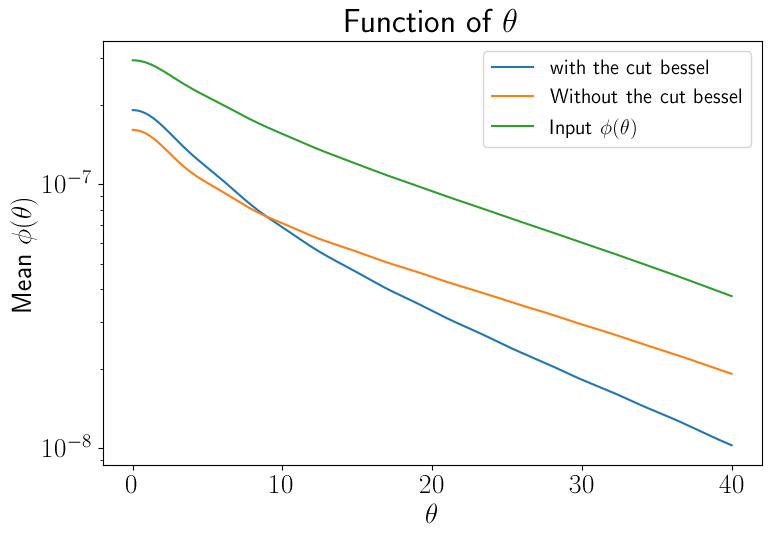

In [78]:
#plt.plot(unique_distances_1*0.3, mean_values_1, label="Without the cut")
#plt.plot(unique_distances_1*0.3, mean_values_2, label="With the cut")
#plt.plot(unique_distances_1*0.3, mean_values_3, label="Input")
plt.plot(theta_1, phi_thet_bessel_c*lbox_rad, label="with the cut bessel")
plt.plot(theta_1, phi_thet_bessel_wc*lbox_rad, label="Without the cut bessel")
plt.plot(theta_1, phi_thet_bessel*lbox_rad, label=r"Input $\phi (\theta)$")

plt.xlabel(r'$\theta$')
plt.ylabel(r'Mean $\phi(\theta)$')
plt.title(r'Function of $\theta$')
plt.semilogy()
#plt.axhline(y=0, c="r")
plt.legend()
plt.show()